# Homework 2: Resnet

Credit: Sohom Paul, Saathvik Selvan, Aryan Jain

In lecture you've seen a history of neural network architectures. In this notebook, we will be implementing one of the most important CNN architectures of the past few years - the ResNet.

For further refernce on ResNet, you can refer to the [original paper](https://arxiv.org/pdf/1512.03385.pdf) or you can read this [fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) on the subject.

In [1]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint

### Part 1: Loading the Data

Recall that `torchvision` gives us direct access to common datasets, which saves us from downloading the data ourselves and writing a custom `DataLoader`. This is really handy for when you're doing some quick prototyping or doing research. We will be using the classic CIFAR-10 dataset. This function may take a few seconds to run because it needs to download the dataset from the internet.

A lot of the dataloading syntax and concepts below should hopefully be review from HW 1!

In [2]:
batch_size = 32
data_root = './data/cifar10'
transform = T.Compose([
    T.ToTensor(),
    # scales pixel values to range [-1, 1]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# We will set up an 80-20 training validation split.
# That is, we will designate 80% of the 50k samples in the CIFAR10 training data as our training set
# and the remaining 20% as the validation set
train_size = 40_000
val_size = 10_000

dataset = torchvision.datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

100%|██████████| 170M/170M [00:06<00:00, 27.4MB/s]


In [3]:
# This line will create the PyTorch dataloaders associated with the training and validation sets.
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

Note that we have downloaded our dataset, let's visualize a few images from it!

showing training images


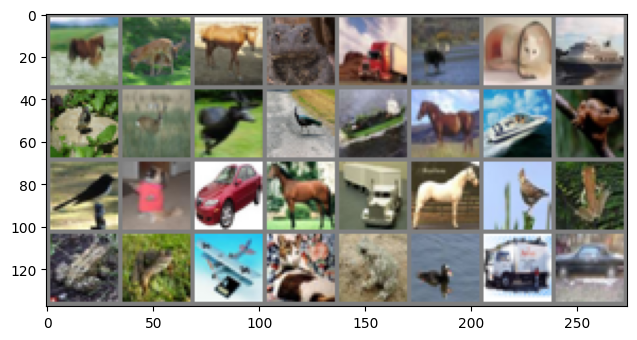


... and their corresponding labels
horse    deer     horse    frog     truck    deer     cat      ship    
bird     deer     deer     bird     ship     horse    ship     frog    
bird     dog      car      horse    truck    horse    bird     frog    
frog     frog     plane    cat      frog     bird     truck    car     


In [4]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

The most basic neural network structure is a fully-connected neural network. This means that every neuron in each layer is connected to every neuron in the previous layer. This also means that every pixel in our image input is connected to every neuron in its immediate next layer. Recall that this is just the Multi-Layer Perceptron that we introduced in the deep learning lecture.

An MLP/FCNN network must take in a vector as input. However, we are passing images to the network below? How do we convert an image to a vector? We can simply flatten it! Any `C x H x W` image can also be represented by a `C*H*W` dimensional vector of its pixel values, which is what we will use as the actual input to your model layers.

Let's try implementing this approach below!

In [5]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future use
        layer_dims: list of integers: the first integer is the input dimension
            and all subsequent elements represent the width
            of each layer in our NN. For simplicity, you may assume
            that len(layer_dims) == 3
        For example, if layer_dims = [100, 50, 10], then this multi-layer
        perceptron will have two linear layers: the first layer will take
        inputs of dimension 100 and output tensors of dimension 50, and the
        second layer will take inputs of dimension 50 and output tensors of
        dimension 10.
        '''
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(layer_dims[0], layer_dims[1])
        self.fc2 = nn.Linear(layer_dims[1], layer_dims[2])


    def forward(self, x):
        '''
        Compute a forward pass of your batch of images

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        # Flatten the image tensor into (batch_size, -1)
        x = x.view(x.size(0), -1)
        # Apply the first linear layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Apply the second linear layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        return x

Here you will get a chance to implement parts of our training and validation loops. If you find yourself struggling, take a look at the training loop from the first homework -- these loops are usually pretty standard and have many similarities regardless of the model.

In [6]:


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, loader):
    total_correct = 0

    # Move model to the proper device and set evaluation mode
    model.to(device)
    model.eval()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(loader, leave=False):
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute the outputs from the model
            outputs = model(inputs)
            # Get predicted class by taking the argmax
            _, preds = torch.max(outputs, dim=1)
            # Count how many predictions are correct
            total_correct += (preds == labels).sum().item()

    return total_correct / len(loader.dataset)

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)

    # Put the model on the right device
    model.to(device)

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()

        for inputs, labels in tqdm(train_loader, leave=False):
            # Move the inputs and labels to the right device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero out the gradients
            optimizer.zero_grad()

            # Compute the model outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Perform an optimizer step
            optimizer.step()

            # Update the total loss
            total_loss += loss.item() * inputs.size(0)  # multiplying by batch size for average loss later

        # Optionally save the model state after each epoch
        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')

        end_time = time.perf_counter()
        duration = end_time - start_time

        # Compute training and validation accuracies
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)

        current_lr = optimizer.param_groups[0]['lr']
        if scheduler and current_lr > 5e-5:
            scheduler.step()

        # Print epoch summary
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'epoch {epoch:2}',
              f'loss: {avg_loss:.3f}',
              f'time: {duration:.3f}s',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}', sep='\t')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [7]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [8]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1.876	time: 12.392s	train acc: 0.4158	val acc: 0.4109


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1.638	time: 11.921s	train acc: 0.4557	val acc: 0.4390


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 1.552	time: 11.927s	train acc: 0.4814	val acc: 0.4562


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1.493	time: 11.932s	train acc: 0.5021	val acc: 0.4716


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1.446	time: 11.482s	train acc: 0.5155	val acc: 0.4764


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1.406	time: 11.742s	train acc: 0.5290	val acc: 0.4842


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1.369	time: 11.868s	train acc: 0.5451	val acc: 0.4928


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1.336	time: 12.014s	train acc: 0.5546	val acc: 0.4966


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1.306	time: 12.109s	train acc: 0.5681	val acc: 0.5037


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1.276	time: 11.959s	train acc: 0.5786	val acc: 0.5091


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1.251	time: 11.877s	train acc: 0.5862	val acc: 0.5100


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1.228	time: 12.076s	train acc: 0.5958	val acc: 0.5060


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1.204	time: 12.073s	train acc: 0.6000	val acc: 0.5060


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1.182	time: 12.262s	train acc: 0.6122	val acc: 0.5127


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1.161	time: 12.194s	train acc: 0.6170	val acc: 0.5138


As a final observation, let's print the number of parameters that this network learned.

In [9]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

You've likely seen in the above example that the validation accuracy of the fully-connected network was not terrible (definitely above the 10% accuracy we'd get from random guessing!), but not too great either.

There are two main issues with fully-connected neural networks. The first is scalability. Because every neuron in each layer is connected to every neuron in the next layer, the number of weights we have in each layer is the product of the sizes of the hidden layers. This means that in order to keep the number of parameters for our model reasonable, we need to either restrict the number of layers or decrease the size of the hidden layers. This prevents us from making very deep fully connected networks that can learn very interesting patterns.

The second issue is that fully connected neural networks are prone to overfitting because they will learn different patterns for each possible pixel in the input image - shifting over the subject of the image by 1 pixel could totally change the output of the network!

These two issues led to the development of the convolutional neural network. The fundamental idea is that instead of connecting all the neurons together, the model instead learns a series of convolutional _kernels_ that it can slide across the image. These kernels make it so that we're applying the same operations to different parts of the image, reducing overfitting, and greatly reduces the number of weights we need, which can improve training time and allow us to train deeper networks.

For more on how CNNs work, check out [this blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) and the lecture slides posted on the course website!

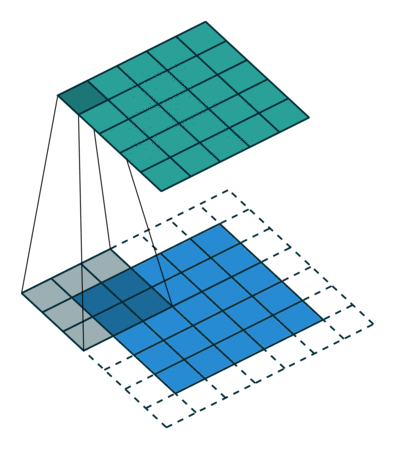

Above: Example convolutional filter. Image courtesy of [Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

Now we implement a basic convolutional neural network. You should check out the PyTorch documentation for [convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to learn more about how these layers should be defined.

In the fully-connected neural network above, we had to flatten each image (or flatten a batch of images) before they could be passed into our linear layers. Do we also need to flatten them before they are passed into a convolutional layer? Hint: look at the documentation above to find out the tensor shape a Conv2D layer expects its input to have.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Change in_channels from 1 to 3 to match the input images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # For a 32x32 input:
        # conv1: (32 - 5 + 1) = 28, pooling: 28/2 = 14
        # conv2: (14 - 5 + 1) = 10, pooling: 10/2 = 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [14]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [15]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2.271	time: 13.963s	train acc: 0.2203	val acc: 0.2185


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2.061	time: 13.328s	train acc: 0.2838	val acc: 0.2852


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 1.822	time: 13.521s	train acc: 0.3713	val acc: 0.3733


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1.618	time: 13.725s	train acc: 0.4356	val acc: 0.4274


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1.515	time: 13.471s	train acc: 0.4770	val acc: 0.4639


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1.440	time: 13.561s	train acc: 0.4972	val acc: 0.4817


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1.388	time: 13.709s	train acc: 0.5193	val acc: 0.5017


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1.340	time: 14.104s	train acc: 0.5274	val acc: 0.5089


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1.296	time: 13.650s	train acc: 0.5543	val acc: 0.5323


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1.256	time: 13.812s	train acc: 0.5717	val acc: 0.5455


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1.223	time: 13.415s	train acc: 0.5816	val acc: 0.5442


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1.190	time: 14.215s	train acc: 0.5928	val acc: 0.5573


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1.154	time: 13.562s	train acc: 0.6045	val acc: 0.5616


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1.125	time: 13.361s	train acc: 0.6217	val acc: 0.5798


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1.097	time: 13.607s	train acc: 0.6207	val acc: 0.5705


In [16]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 61530
Ratio: 0.19957185949206968


So we've improved validation accuracy while using 80% fewer parameters. Nice!

### Part 4: Using ResNet for Classification

The network that we're implementing here is the residual network (ResNet), a CNN variant and one of the most important networks in modern computer vision.

The fundamental idea behind ResNet is the _skip connection_. In very deep neural networks, we frequently run into the _vanishing gradient problem_, where updates during backpropagation can be multiplied by very small numbers and result in the first few layers of the network learning very slowly. Skip connections rectify this problem by having outputs of some layers jump ahead so they can skip a few layers and get added in later on. This means that gradient updates have to travel back a shorter distance to update the earlier layers in the network.

The reason that it's called a residual network is because our residual blocks, instead of learning the function $f(x)$, instead learn the _residual_ $f(x) - x$. The input $x$ gets added back in using the skip connection.

For more details, try checking out the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) or [this fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Because this is a fairly involved architecture, we will only ask you to implement a single residual block of a ResNet18 model. We will then chain these blocks to contruct the overall ResNet model.

In [27]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Create a residual block for ResNet18.

        Network structure:
        - First convolution: 3x3, out_channels, stride=stride, padding=1, no bias
        - Batch normalization
        - ReLU activation
        - Second convolution: 3x3, out_channels, stride=1, padding=1, no bias
        - Batch normalization
        - Shortcut:
            - If stride != 1 or in_channels != out_channels, use a 3x3 conv (with stride=stride)
              and batchnorm to match dimensions.
            - Otherwise, use a no-op (identity).
        - Final output: add shortcut to the second batchnorm output, then apply ReLU.
        """
        super(ResNetBlock, self).__init__()

        # First conv + batchnorm
        self.conv1 = self.conv(in_channels, out_channels, kernel_size=3, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second conv + batchnorm
        self.conv2 = self.conv(out_channels, out_channels, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut layer: if dimensions differ, use a convolution and batchnorm; otherwise identity.
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                self.conv(in_channels, out_channels, kernel_size=3, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        # First conv, batchnorm, and ReLU activation.
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Second conv and batchnorm.
        out = self.conv2(out)
        out = self.bn2(out)

        # Compute shortcut (either identity or a conv + batchnorm block).
        shortcut = self.shortcut(x)

        # Add shortcut and apply final ReLU.
        out = F.relu(out + shortcut)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64
        self.layer1 = self.make_block(out_channels=64, stride=1, rep=2)
        self.layer2 = self.make_block(out_channels=128, stride=2, rep=2)
        self.layer3 = self.make_block(out_channels=256, stride=2, rep=2)
        self.layer4 = self.make_block(out_channels=512, stride=2, rep=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride, rep):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [20]:
num_epochs = 15
resnet = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

Now that we have defined our model, feel free to use this `torchsummary` package function to visualize how an image is passed through the network and how the layers change the shape of the image. The final convolution layer should output a tensor of size `(32, 512, 4, 4)`, which is averaged, flattened, and passed through a fully connected layer to end up with a `(32, 10)` tensor of classification scores. To evaluate predictions, we simply take the `argmax` of our output.



In [21]:
resnet = resnet.to(device)
summary(resnet, input_size = (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
            Conv2d-3           [32, 64, 32, 32]          36,864
       BatchNorm2d-4           [32, 64, 32, 32]             128
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
       ResNetBlock-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
           Conv2d-10           [32, 64, 32, 32]          36,864
      BatchNorm2d-11           [32, 64, 32, 32]             128
      ResNetBlock-12           [32, 64, 32, 32]               0
           Conv2d-13          [32, 128, 16, 16]          73,728
      BatchNorm2d-14          [32, 128,

This model will take about 20 minutes to train. Make sure that you are connected to a GPU runtime for Colab or, if you have GPU on your computer, consider training locally. Watch out for Colab's runtime disconnecting; it shouldn't be a big problem for this homework, but make sure to keep the browser tab open while the models are training.

The staff implementation got a validation accuracy of ~60% after 1 training epoch. If your results are significantly worse than that, consider stopping your training run and debugging your model.

In [22]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_resnet')

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1.376	time: 44.818s	train acc: 0.6777	val acc: 0.6339


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 0.869	time: 45.626s	train acc: 0.7707	val acc: 0.7081


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 0.613	time: 46.520s	train acc: 0.8553	val acc: 0.7482


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 0.433	time: 46.522s	train acc: 0.8869	val acc: 0.7432


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 0.286	time: 46.539s	train acc: 0.9536	val acc: 0.7755


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 0.176	time: 46.658s	train acc: 0.9591	val acc: 0.7611


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 0.118	time: 46.693s	train acc: 0.9707	val acc: 0.7665


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 0.080	time: 46.820s	train acc: 0.9723	val acc: 0.7684


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 0.061	time: 46.530s	train acc: 0.9937	val acc: 0.7996


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 0.038	time: 46.693s	train acc: 0.9950	val acc: 0.7979


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 0.032	time: 46.439s	train acc: 0.9966	val acc: 0.7922


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 0.019	time: 46.577s	train acc: 0.9993	val acc: 0.8074


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 0.012	time: 46.733s	train acc: 1.0000	val acc: 0.8153


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 0.007	time: 46.692s	train acc: 0.9997	val acc: 0.8153


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 0.007	time: 46.625s	train acc: 1.0000	val acc: 0.8097


And there we have it! Just by adding these skip connections, we dramatically improved the classification accuracy compared to a vanilla CNN!

### Part 5: Optimizing Hyperparameters and Other Tricks

In this section, you will be trying to achieve a **validation accuracy** of **at least 85%** on the same CIFAR-10 Dataset. Below, we have provided code to allow you to change various properties of your model, training procedure, and dataset augmentations. You are allowed to use whatever you wish except loading in pretrained models. However, creating your own model architecture below using any of the tricks we have learnt in class is fair game.

Here are some things you can probably experiment with:
- Batch size
- Learning rate
- Optimizer
- Number of epochs
- Image transforms/augmentations
- Adding/removing/modifying conv and linear layers
- Adding dropout, batchnorm, etc.

In [28]:
try:
    import shutil
    shutil.rmtree("./data")
    del train_loader, val_loader
except:
    pass

data_root = './data/cifar10'
train_size = 40_000
val_size = 10_000

# ====== YOUR CODE (Filled In) ======
# You can modify batch_size, mean/std, and the data augmentations as desired.
batch_size = 32

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.95, 1.05)),
    T.Normalize(mean, std),
])
# ====== END YOUR CODE ======

transform_val = T.Compose([
    T.Normalize(mean, std),
])

# Download CIFAR10 dataset
dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=T.ToTensor()
)

# Ensure we don't sample more elements than available
assert train_size + val_size <= len(dataset), (
    "Trying to sample too many elements! Please lower the train or validation set sizes."
)

# Split the indices for train/val
train_split, val_split, _ = torch.utils.data.random_split(
    range(len(dataset)),
    [train_size, val_size, len(dataset) - train_size - val_size]
)

class CustomTransformDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.transform = transform
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        return self.transform(x), y

# Create datasets using our custom transforms
train_set = CustomTransformDataset(dataset, train_split, transform=transform_train)
val_set  = CustomTransformDataset(dataset, val_split,  transform=transform_val)

# Create DataLoaders
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)


100%|██████████| 170M/170M [00:06<00:00, 27.7MB/s]


You can visualize the effects of your data augmentations on the training set by running the cell below:

showing training images


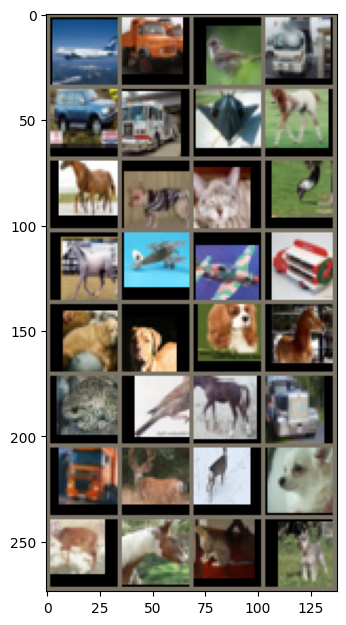


... and their corresponding labels
plane    truck    bird     truck   
car      truck    plane    horse   
horse    dog      cat      bird    
horse    plane    plane    truck   
dog      dog      dog      horse   
frog     bird     horse    truck   
truck    deer     deer     dog     
deer     horse    cat      dog     


In [29]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img * std.reshape(-1, 1, 1) + mean.reshape(-1, 1, 1)
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 8
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

In [35]:
## Feel free to create a bigger resnet model, or use a completely different CNN architecture.
## You can also choose to modify the ResNet model above (in which case, we do ask that you copy it down below
## before making any changes to it; we want to keep your implementation above separate for the model you define
## here for grading purposes).
## The goal of this problem is for you to apply all of the deep learning tricks we have learnt so far
## to try and maximize the validation accuracy on CIFAR-10 as much as possible.
final_cnn = ResNet18(num_classes=10)

In [37]:
## YOUR CODE HERE
## TODO: Modify the given hyperparameters if you wish
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_cnn.parameters(), lr=1e-3, momentum=0.9)
## You can also add a learning rate scheduler if you want to experiment with one
scheduler = None  # For example, you could try: optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
## END YOUR CODE

train(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_final_cnn', scheduler)


beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1.386	time: 50.673s	train acc: 0.5922	val acc: 0.6030


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1.043	time: 51.071s	train acc: 0.6582	val acc: 0.6511


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 0.846	time: 51.460s	train acc: 0.7331	val acc: 0.7387


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 0.726	time: 51.591s	train acc: 0.7814	val acc: 0.7753


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 0.644	time: 51.640s	train acc: 0.8048	val acc: 0.7914


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 0.579	time: 51.322s	train acc: 0.8072	val acc: 0.7981


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 0.524	time: 51.611s	train acc: 0.8227	val acc: 0.8140


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 0.487	time: 50.989s	train acc: 0.8417	val acc: 0.8221


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 0.452	time: 50.753s	train acc: 0.8530	val acc: 0.8336


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 0.419	time: 51.820s	train acc: 0.8728	val acc: 0.8402


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 0.392	time: 51.293s	train acc: 0.8873	val acc: 0.8588


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 0.370	time: 51.495s	train acc: 0.8778	val acc: 0.8508


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 0.350	time: 51.196s	train acc: 0.8805	val acc: 0.8614


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 0.329	time: 50.984s	train acc: 0.8910	val acc: 0.8605


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 0.309	time: 51.060s	train acc: 0.9002	val acc: 0.8645


### Part 6: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a pickle file that will contain your model's predictions on the CIFAR-10 validation set --- tampering with the code block below might mess up the file that you will submit to the Gradescope autograder.

In [38]:
import pickle

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

cifar_test = datasets.CIFAR10('.', download = True, train = False, transform = transform)
loader_test = DataLoader(cifar_test, batch_size=32, shuffle=False)

final_cnn.eval()  # set model to evaluation mode
predictions = []
with torch.no_grad():
    for x, _ in loader_test:
        x = x.to(device=device)  # move to device, e.g. GPU
        scores = final_cnn(x)
        _, preds = scores.max(1)
        predictions.append(preds)
predictions = torch.cat(predictions).tolist()
with open("cnn_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)

100%|██████████| 170M/170M [00:07<00:00, 23.1MB/s]
